### Random Forest Model

In [39]:
import pandas as pd
import os
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [40]:
TMDB_filename = os.path.join(os.getcwd(), "TMDB_tv_dataset_v3.csv")
df = pd.read_csv(TMDB_filename)

In [3]:
"""
# Fill missing values for numerical + categorical columns with mean
numerical_cols = df.select_dtypes(include=['float64', 'int64', 'bool']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

categorical_cols = df.select_dtypes(include=['object']).columns
columns_to_fill = [col for col in categorical_cols if col != 'genres']
df[columns_to_fill] = df[columns_to_fill].apply(lambda col: col.fillna('Unknown'))
#df[columns_to_fill] = df[columns_to_fill].apply(lambda col: col.fillna(col.mode()[0]))

# Remove duplicates
df = df.drop_duplicates()

df['genres'] = df['genres'].fillna('Unknown') # for genres that are empty just call them Unknown
df['genres'] = df['genres'].apply(lambda x: x.split(', '))

unique_genres = sorted(set(genre for genres in df['genres'] for genre in genres))

for genre in unique_genres:
  df[genre] = df['genres'].apply(lambda genres: int(genre in genres))

# Do NOT drop genres yet, we will still keep it for the later steps
# df = df.drop('genres', axis=1)

# Columns not included are name, overview, backdrop_path, homepage, original_name, poster_path, tagline, languages, spoken_languages,production_countries, and cleaned_overview
encode_cols =['original_language','type', 'status','created_by','networks','origin_country','production_companies']

# Creating a list of the top 20 values in the original_language column
top_10_original_language = df['original_language'].value_counts(ascending = False).head(10).index.tolist()

# Creating one-hot encoded columns for original_language
for i in top_10_original_language:
    name = 'original-language_' + i
    df[name] = np.where(df['original_language'] == i, 1, 0)

# Removing the original_language column from df and encode_cols
df.drop(columns = ['original_language'], inplace = True)
encode_cols.remove('original_language')

filtered_df = df[df['created_by'] != 'Unknown']

# Creating a list of the top 10 values in the created_by column
top_10_created_by = filtered_df['created_by'].value_counts(ascending=False).head(10).index.tolist()

# Creating one-hot encoded columns for created_by
for i in top_10_created_by:
    name = 'created-by_' + i
    df[name] = np.where(df['created_by'] == i, 1, 0)

# Removing the created_by column from df and encode_cols
df.drop(columns = ['created_by'], inplace = True)
encode_cols.remove('created_by')

# Creating a list of the top 11 values in the networks column
filtered_df = df[df['networks'] != 'Unknown']

top_10_networks = filtered_df['networks'].value_counts(ascending = False).head(10).index.tolist()

# Creating one-hot encoded columns for networks

for i in top_10_networks:
    name = 'networks_' + i
    df[name] = np.where(df['networks'] == i, 1, 0)

# Removing the networks column from df and encode_cols
df.drop(columns = ['networks'], inplace = True)
encode_cols.remove('networks')

# Creating a list of the top 10 values in the origin_country column
filtered_df = df[df['origin_country'] != 'Unknown']

top_10_origin_country = filtered_df['origin_country'].value_counts(ascending = False).head(10).index.tolist()

df['origin_country'] = df['origin_country'].fillna('Unknown')

one_hot_encoded = pd.get_dummies(df['origin_country'], prefix='origin-country')

one_hot_encoded = one_hot_encoded[[f'origin-country_{i}' for i in top_10_origin_country if f'origin-country_{i}' in one_hot_encoded]]
one_hot_encoded['origin-country_OTHER'] = (~df['origin_country'].isin(top_10_origin_country)).astype(int)

df = pd.concat([df, one_hot_encoded], axis=1)

# Removing the origin_country column from df and encode_cols
df.drop(columns = ['origin_country'], inplace = True)
encode_cols.remove('origin_country')

# Creating a list of the top 10 values in the production_companies column
filtered_df = df[df['production_companies'] != 'Unknown']

top_10_production_companies = filtered_df['production_companies'].value_counts(ascending = False).head(10).index.tolist()


one_hot_encoded_production_companies = pd.DataFrame() # start with an empty dataframe

for i in top_10_origin_country:
    one_hot_encoded_production_companies['production-companies_' + i] = np.where(df['production_companies'] == i, 1, 0)

# the we can concatenate the one-hot encoded columns to the original DataFrame
df = pd.concat([df, one_hot_encoded_production_companies], axis=1)

# Removing the production_companies column from df and encode_cols
df.drop(columns = ['production_companies'], inplace = True)
encode_cols.remove('production_companies')


# One-hot encoding remaining columns
for colname in encode_cols:
    df_encoded = pd.get_dummies(df[colname], prefix=colname+'')
    df = df.join(df_encoded)

# Removing remaining original cols from df
df.drop(columns=encode_cols,axis=1,inplace=True)
"""


In [41]:
# Fill missing values for numerical + categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64', 'bool']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

categorical_cols = df.select_dtypes(include=['object']).columns
columns_to_fill = [col for col in categorical_cols if col != 'genres']
df[columns_to_fill] = df[columns_to_fill].apply(lambda col: col.fillna('Unknown'))

# Remove duplicates
df = df.drop_duplicates()

# Handle 'genres' column (multi-label encoding)
df['genres'] = df['genres'].fillna('Unknown')
df['genres'] = df['genres'].apply(lambda x: x.split(', '))
unique_genres = sorted(set(genre for genres in df['genres'] for genre in genres))

for genre in unique_genres:
    df[genre] = df['genres'].apply(lambda genres: int(genre in genres))

# Retain 'genres' column for now as per the requirement
# Columns to encode
encode_cols = ['original_language', 'type', 'status', 'created_by', 'networks', 'origin_country', 'production_companies']

# One-hot encoding for 'original_language' (top 10 values + 'OTHER')
top_10_original_language = df['original_language'].value_counts(ascending=False).head(10).index.tolist()
for i in top_10_original_language:
    df[f'original-language_{i}'] = np.where(df['original_language'] == i, 1, 0)
df['original-language_OTHER'] = (~df['original_language'].isin(top_10_original_language)).astype(int)
df.drop(columns=['original_language'], inplace=True)
encode_cols.remove('original_language')

# One-hot encoding for 'created_by' (top 10 values + 'OTHER')
filtered_df = df[df['created_by'] != 'Unknown']
top_10_created_by = filtered_df['created_by'].value_counts(ascending=False).head(10).index.tolist()
for i in top_10_created_by:
    df[f'created-by_{i}'] = np.where(df['created_by'] == i, 1, 0)
df['created-by_OTHER'] = (~df['created_by'].isin(top_10_created_by)).astype(int)
df.drop(columns=['created_by'], inplace=True)
encode_cols.remove('created_by')

# One-hot encoding for 'networks' (top 10 values + 'OTHER')
filtered_df = df[df['networks'] != 'Unknown']
top_10_networks = filtered_df['networks'].value_counts(ascending=False).head(10).index.tolist()
for i in top_10_networks:
    df[f'networks_{i}'] = np.where(df['networks'] == i, 1, 0)
df['networks_OTHER'] = (~df['networks'].isin(top_10_networks)).astype(int)
df.drop(columns=['networks'], inplace=True)
encode_cols.remove('networks')

# One-hot encoding for 'origin_country' (top 10 values + 'OTHER')
df['origin_country'] = df['origin_country'].fillna('Unknown')
filtered_df = df[df['origin_country'] != 'Unknown']
top_10_origin_country = filtered_df['origin_country'].value_counts(ascending=False).head(10).index.tolist()
one_hot_encoded = pd.get_dummies(df['origin_country'], prefix='origin-country')
one_hot_encoded = one_hot_encoded[[f'origin-country_{i}' for i in top_10_origin_country if f'origin-country_{i}' in one_hot_encoded]]
one_hot_encoded['origin-country_OTHER'] = (~df['origin_country'].isin(top_10_origin_country)).astype(int)
df = pd.concat([df, one_hot_encoded], axis=1)
df.drop(columns=['origin_country'], inplace=True)
encode_cols.remove('origin_country')

# One-hot encoding for 'production_companies' (top 10 values + 'OTHER')
df['production_companies'] = df['production_companies'].fillna('Unknown')
filtered_df = df[df['production_companies'] != 'Unknown']
top_10_production_companies = filtered_df['production_companies'].value_counts(ascending=False).head(10).index.tolist()
for i in top_10_production_companies:
    df[f'production-companies_{i}'] = np.where(df['production_companies'] == i, 1, 0)
df['production-companies_OTHER'] = (~df['production_companies'].isin(top_10_production_companies)).astype(int)
df.drop(columns=['production_companies'], inplace=True)
encode_cols.remove('production_companies')

# One-hot encoding for remaining columns
for colname in encode_cols:
    df_encoded = pd.get_dummies(df[colname], prefix=colname)
    df = pd.concat([df, df_encoded], axis=1)

# Removing remaining original columns from df
df.drop(columns=encode_cols, axis=1, inplace=True)

# Save the final DataFrame
df.to_csv('TMDB_tv_dataset_v3.csv', index=False)

# Print final DataFrame columns to verify
print(df.columns)

Index(['id', 'name', 'number_of_seasons', 'number_of_episodes', 'vote_count',
       'vote_average', 'overview', 'adult', 'backdrop_path', 'first_air_date',
       ...
       'type_Reality', 'type_Scripted', 'type_Talk Show', 'type_Video',
       'status_Canceled', 'status_Ended', 'status_In Production',
       'status_Pilot', 'status_Planned', 'status_Returning Series'],
      dtype='object', length=111)


In [42]:
# Iterate through the columns and print each
for col in df.columns:
    print(col)

id
name
number_of_seasons
number_of_episodes
vote_count
vote_average
overview
adult
backdrop_path
first_air_date
last_air_date
homepage
in_production
original_name
popularity
poster_path
tagline
genres
languages
spoken_languages
production_countries
episode_run_time
Action & Adventure
Animation
Comedy
Crime
Documentary
Drama
Family
History
Kids
Music
Musical
Mystery
News
Reality
Romance
Sci-Fi & Fantasy
Soap
Talk
Unknown
War & Politics
Western
original-language_en
original-language_zh
original-language_ja
original-language_ko
original-language_de
original-language_fr
original-language_es
original-language_pt
original-language_ru
original-language_nl
original-language_OTHER
created-by_Shotaro Ishinomori
created-by_John de Mol
created-by_Adrián Suar
created-by_Simon Fuller
created-by_Ekta Kapoor
created-by_Na Young-seok
created-by_Yang Li-Hua
created-by_Joseph Barbera, William Hanna
created-by_R.J. Nuevas
created-by_Mark Burnett
created-by_OTHER
networks_BBC One
networks_YouTube
networks

In [43]:
# convert the boolean values to integers (True -> 1, False -> 0)
df['adult'] = df['adult'].astype(int)

In [45]:
# Replace "Unknown" and other invalid date strings with NaT (Not a Time)
df['first_air_date'] = pd.to_datetime(df['first_air_date'], format='%Y-%m-%d', errors='coerce')
df['last_air_date'] = pd.to_datetime(df['last_air_date'], format='%Y-%m-%d', errors='coerce')

# Check the data types to confirm conversion
print(df['first_air_date'].dtypes)
print(df['last_air_date'].dtypes)

# Creating a function to determine the season based on the month
def get_season(date):
    if pd.isna(date):  # Handle NaT values
        return 'UNKNOWN'
    month = date.month
    if month in [12, 1, 2]:
        return 'WINTER'
    elif month in [3, 4, 5]:
        return 'SPRING'
    elif month in [6, 7, 8]:
        return 'SUMMER'
    elif month in [9, 10, 11]:
        return 'FALL'
    else:
        return 'UNKNOWN'

# Creating a column with the seasons for `first_air_date`
df['first_air_date_season'] = df['first_air_date'].apply(get_season)

# Creating boolean columns for each season
df['first_air_date_winter'] = (df['first_air_date_season'] == 'WINTER').astype(int)
df['first_air_date_spring'] = (df['first_air_date_season'] == 'SPRING').astype(int)
df['first_air_date_summer'] = (df['first_air_date_season'] == 'SUMMER').astype(int)
df['first_air_date_fall'] = (df['first_air_date_season'] == 'FALL').astype(int)

# Repeating the same process for `last_air_date`
df['last_air_date_season'] = df['last_air_date'].apply(get_season)

df['last_air_date_winter'] = (df['last_air_date_season'] == 'WINTER').astype(int)
df['last_air_date_spring'] = (df['last_air_date_season'] == 'SPRING').astype(int)
df['last_air_date_summer'] = (df['last_air_date_season'] == 'SUMMER').astype(int)
df['last_air_date_fall'] = (df['last_air_date_season'] == 'FALL').astype(int)

# Confirm the columns
print(df[['first_air_date_season', 'last_air_date_season']].head())


datetime64[ns]
datetime64[ns]
  first_air_date_season last_air_date_season
0                SPRING               SPRING
1                SPRING               WINTER
2                SUMMER               SUMMER
3                  FALL                 FALL
4                WINTER                 FALL


In [46]:
# List of original numerical columns
numerical_columns = ['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 'popularity', 'episode_run_time']

# Apply log transformation and rename columns with "_log"
df_log = df[numerical_columns].apply(lambda x: np.log1p(x)).add_suffix('_log')

# Concatenate the log-transformed columns with the original DataFrame
df = pd.concat([df, df_log], axis=1)

# Display the DataFrame to confirm new columns
print(df.head())

# List of log-transformed numerical columns
numerical_columns_log = [col + '_log' for col in numerical_columns]

# Display summary statistics for log-transformed columns
print(df[numerical_columns_log].describe())

      id              name  number_of_seasons  number_of_episodes  vote_count  \
0   1399   Game of Thrones                  8                  73       21857   
1  71446       Money Heist                  3                  41       17836   
2  66732   Stranger Things                  4                  34       16161   
3   1402  The Walking Dead                 11                 177       15432   
4  63174           Lucifer                  6                  93       13870   

   vote_average                                           overview  adult  \
0         8.442  Seven noble families fight for control of the ...      0   
1         8.257  To carry out the biggest heist in history, a m...      0   
2         8.624  When a young boy vanishes, a small town uncove...      0   
3         8.121  Sheriff's deputy Rick Grimes awakens from a co...      0   
4         8.486  Bored and unhappy as the Lord of Hell, Lucifer...      0   

                      backdrop_path first_air_date

In [47]:
# Iterate through the columns and print each
for col in df.columns:
    print(col)

id
name
number_of_seasons
number_of_episodes
vote_count
vote_average
overview
adult
backdrop_path
first_air_date
last_air_date
homepage
in_production
original_name
popularity
poster_path
tagline
genres
languages
spoken_languages
production_countries
episode_run_time
Action & Adventure
Animation
Comedy
Crime
Documentary
Drama
Family
History
Kids
Music
Musical
Mystery
News
Reality
Romance
Sci-Fi & Fantasy
Soap
Talk
Unknown
War & Politics
Western
original-language_en
original-language_zh
original-language_ja
original-language_ko
original-language_de
original-language_fr
original-language_es
original-language_pt
original-language_ru
original-language_nl
original-language_OTHER
created-by_Shotaro Ishinomori
created-by_John de Mol
created-by_Adrián Suar
created-by_Simon Fuller
created-by_Ekta Kapoor
created-by_Na Young-seok
created-by_Yang Li-Hua
created-by_Joseph Barbera, William Hanna
created-by_R.J. Nuevas
created-by_Mark Burnett
created-by_OTHER
networks_BBC One
networks_YouTube
networks

In [48]:
#Winsorization
from scipy.stats.mstats import winsorize

# Define the limits for Winsorization
lower_limit = 0.05  # 5th percentile
upper_limit = 0.95  # 95th percentile

# Winsorize each numerical column in-place
for col in numerical_columns:
    df[col] = winsorize(df[col], limits=(lower_limit, 1 - upper_limit))

# Winsorize each log-transformed numerical column in-place
for col in numerical_columns_log:
    df[col] = winsorize(df[col], limits=(lower_limit, 1 - upper_limit))


In [49]:
# Normalize
from sklearn.preprocessing import MinMaxScaler

# Select numerical columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling in-place
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Display the updated DataFrame to confirm normalized columns
print(df.head())

         id              name  number_of_seasons  number_of_episodes  \
0  0.005565   Game of Thrones               1.00            0.802198   
1  0.284401       Money Heist               0.75            0.450549   
2  0.265636   Stranger Things               1.00            0.373626   
3  0.005577  The Walking Dead               1.00            1.000000   
4  0.251473           Lucifer               1.00            1.000000   

   vote_count  vote_average  \
0         1.0      0.938000   
1         1.0      0.917444   
2         1.0      0.958222   
3         1.0      0.902333   
4         1.0      0.942889   

                                            overview  adult  \
0  Seven noble families fight for control of the ...    0.0   
1  To carry out the biggest heist in history, a m...    0.0   
2  When a young boy vanishes, a small town uncove...    0.0   
3  Sheriff's deputy Rick Grimes awakens from a co...    0.0   
4  Bored and unhappy as the Lord of Hell, Lucifer...    0.0   

 

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

In [51]:
X = df[['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 'episode_run_time']]
y = df['popularity']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions on test data
rf_predictions_test = rf.predict(X_test)

# Predictions on train data
rf_predictions_train = rf.predict(X_train)

# Calculate evaluation metrics for test set
test_mae = mean_absolute_error(y_test, rf_predictions_test)
test_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions_test))
test_r2 = r2_score(y_test, rf_predictions_test)

# Calculate evaluation metrics for train set
train_mae = mean_absolute_error(y_train, rf_predictions_train)
train_rmse = np.sqrt(mean_squared_error(y_train, rf_predictions_train))
train_r2 = r2_score(y_train, rf_predictions_train)

print("Results with regular dataset, 4 numerical features:")
# Print Train set evaluation metrics
print(f'Train MAE: {train_mae:.4f}')
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Train R^2: {train_r2:.4f}')

# Print Test set evaluation metrics
print(f'Test MAE: {test_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test R^2: {test_r2:.4f}')

Results with regular dataset, 4 numerical features:
Train MAE: 0.0584
Train RMSE: 0.1190
Train R^2: 0.7842
Test MAE: 0.0872
Test RMSE: 0.1705
Test R^2: 0.5494


In [17]:
"""
df['popularity'] = df['popularity'].fillna(df['popularity'].mean())
df['popularity_log'] = df['popularity_log'].fillna(df['popularity_log'].mean())
y.isnull().sum()
"""

1534

In [52]:
X = df[['number_of_seasons_log', 'number_of_episodes_log', 'vote_count_log', 'vote_average_log', 'episode_run_time']]
y = df['popularity_log']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions on test data
rf_predictions_test = rf.predict(X_test)

# Predictions on train data
rf_predictions_train = rf.predict(X_train)

# Calculate evaluation metrics for test set
test_mae = mean_absolute_error(y_test, rf_predictions_test)
test_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions_test))
test_r2 = r2_score(y_test, rf_predictions_test)

# Calculate evaluation metrics for train set
train_mae = mean_absolute_error(y_train, rf_predictions_train)
train_rmse = np.sqrt(mean_squared_error(y_train, rf_predictions_train))
train_r2 = r2_score(y_train, rf_predictions_train)

print("Results with Log Transformation, 4 features:")
# Print Train set evaluation metrics
print(f'Train MAE: {train_mae:.4f}')
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Train R^2: {train_r2:.4f}')

# Print Test set evaluation metrics
print(f'Test MAE: {test_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test R^2: {test_r2:.4f}')

Results with Log Transformation, 4 features:
Train MAE: 0.0904
Train RMSE: 0.1440
Train R^2: 0.7605
Test MAE: 0.1204
Test RMSE: 0.1850
Test R^2: 0.5993


In [53]:
X = df[['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 
        'episode_run_time', 'Action & Adventure', 'Animation', 'Comedy', 'Crime', 
        'Documentary', 'Drama', 'Family', 'History', 'Kids', 'Music', 'Musical', 
        'Mystery', 'News', 'Reality', 'Romance', 'Sci-Fi & Fantasy', 'Soap', 
        'Talk', 'Unknown', 'War & Politics', 'Western']]
y = df['popularity']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions on test data
rf_predictions_test = rf.predict(X_test)

# Predictions on train data
rf_predictions_train = rf.predict(X_train)

# Calculate evaluation metrics for test set
test_mae = mean_absolute_error(y_test, rf_predictions_test)
test_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions_test))
test_r2 = r2_score(y_test, rf_predictions_test)

# Calculate evaluation metrics for train set
train_mae = mean_absolute_error(y_train, rf_predictions_train)
train_rmse = np.sqrt(mean_squared_error(y_train, rf_predictions_train))
train_r2 = r2_score(y_train, rf_predictions_train)

print("Results with Genres Features:")
# Print Train set evaluation metrics
print(f'Train MAE: {train_mae:.4f}')
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Train R^2: {train_r2:.4f}')

# Print Test set evaluation metrics
print(f'Test MAE: {test_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test R^2: {test_r2:.4f}')

Results with Genres Features:
Train MAE: 0.0471
Train RMSE: 0.0979
Train R^2: 0.8538
Test MAE: 0.0842
Test RMSE: 0.1661
Test R^2: 0.5726


In [55]:
X = df[['number_of_seasons_log', 'number_of_episodes_log', 'vote_count_log', 
        'vote_average_log', 'episode_run_time_log', 
        # Genres
        'Action & Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 
        'Drama', 'Family', 'History', 'Kids', 'Music', 'Musical', 'Mystery', 
        'News', 'Reality', 'Romance', 'Sci-Fi & Fantasy', 'Soap', 'Talk', 
        'Unknown', 'War & Politics', 'Western',
        # Original Language
        'original-language_en', 'original-language_zh', 'original-language_ja', 
        'original-language_ko', 'original-language_de', 'original-language_fr', 
        'original-language_es', 'original-language_pt', 'original-language_ru', 
        'original-language_nl', 'original-language_OTHER', 
        # Created By
        'created-by_Shotaro Ishinomori', 'created-by_John de Mol', 
        'created-by_Adrián Suar', 'created-by_Simon Fuller', 
        'created-by_Ekta Kapoor', 'created-by_Na Young-seok', 
        'created-by_Yang Li-Hua', 'created-by_Joseph Barbera, William Hanna', 
        'created-by_R.J. Nuevas', 'created-by_Mark Burnett', 
        'created-by_OTHER', 
        # Networks
        'networks_BBC One', 'networks_YouTube', 'networks_Netflix', 
        'networks_ITV1', 'networks_BBC Two', 'networks_ABC', 'networks_NBC', 
        'networks_TVB Jade', 'networks_CBS', 'networks_Channel 4', 
        'networks_OTHER', 
        # Origin Country
        'origin-country_US', 'origin-country_JP', 'origin-country_GB', 
        'origin-country_CN', 'origin-country_DE', 'origin-country_KR', 
        'origin-country_CA', 'origin-country_FR', 'origin-country_AU', 
        'origin-country_BR', 'origin-country_OTHER', 
        # Production Companies
        'production-companies_TVB', 'production-companies_BBC', 
        'production-companies_Estúdios Globo', 'production-companies_NHK', 
        'production-companies_DR TV', 'production-companies_TV 2', 
        'production-companies_Televisa', 'production-companies_GMA Entertainment Group', 
        'production-companies_Česká televize', 'production-companies_ATV Enterprises Limited', 
        'production-companies_OTHER', 
        # Types
        'type_Documentary', 'type_Miniseries', 'type_News', 'type_Reality', 
        'type_Scripted', 'type_Talk Show', 'type_Video', 
        # Status
        'status_Canceled', 'status_Ended', 'status_In Production', 
        'status_Pilot', 'status_Planned', 'status_Returning Series'
]]
y = df['popularity_log']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions on test data
rf_predictions_test = rf.predict(X_test)

# Predictions on train data
rf_predictions_train = rf.predict(X_train)

# Calculate evaluation metrics for test set
test_mae = mean_absolute_error(y_test, rf_predictions_test)
test_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions_test))
test_r2 = r2_score(y_test, rf_predictions_test)

# Calculate evaluation metrics for train set
train_mae = mean_absolute_error(y_train, rf_predictions_train)
train_rmse = np.sqrt(mean_squared_error(y_train, rf_predictions_train))
train_r2 = r2_score(y_train, rf_predictions_train)

print("Results with Log Transformation + One-Hot Encoded Features:")
# Print Train set evaluation metrics
print(f'Train MAE: {train_mae:.4f}')
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Train R^2: {train_r2:.4f}')

# Print Test set evaluation metrics
print(f'Test MAE: {test_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test R^2: {test_r2:.4f}')

Results with Log Transformation + One-Hot Encoded Features:
Train MAE: 0.0540
Train RMSE: 0.0908
Train R^2: 0.9048
Test MAE: 0.1065
Test RMSE: 0.1693
Test R^2: 0.6645


In [24]:
"""
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define the model with potential regularization parameters
rf_model = RandomForestRegressor(random_state=42)

# Set up parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluate best estimator
best_rf_model = grid_search.best_estimator_
train_predictions = best_rf_model.predict(X_train)
test_predictions = best_rf_model.predict(X_test)

# Calculate updated metrics
train_mae = mean_absolute_error(y_train, train_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_r2 = r2_score(y_train, train_predictions)

test_mae = mean_absolute_error(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)

print("Results with Tuned Random Forest:")
print(f'Train MAE: {train_mae:.4f}')
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Train R^2: {train_r2:.4f}')
print(f'Test MAE: {test_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test R^2: {test_r2:.4f}')
"""

'\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score\nimport numpy as np\n\n# Define the model with potential regularization parameters\nrf_model = RandomForestRegressor(random_state=42)\n\n# Set up parameter grid for tuning\nparam_grid = {\n    \'n_estimators\': [50, 100],\n    \'max_depth\': [None, 10, 20],\n    \'min_samples_split\': [2, 10],\n    \'min_samples_leaf\': [1, 4]\n}\n\n# Perform Grid Search with Cross-Validation\ngrid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring=\'neg_mean_squared_error\', n_jobs=-1)\ngrid_search.fit(X_train, y_train)\n\n# Evaluate best estimator\nbest_rf_model = grid_search.best_estimator_\ntrain_predictions = best_rf_model.predict(X_train)\ntest_predictions = best_rf_model.predict(X_test)\n\n# Calculate updated metrics\ntrain_mae = mean_absolute_error(y_train, train_predictions)\ntrain_rmse = np.sqrt(mean_squar

In [20]:
"""
# Print the best parameters found
print("Best Parameters for Random Forest:", grid_search.best_params_)
"""

Best Parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [56]:
# Define features and target variable
X = df[['number_of_seasons_log', 'number_of_episodes_log', 'vote_count_log', 
        'vote_average_log', 'episode_run_time_log', 
        # Genres
        'Action & Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 
        'Drama', 'Family', 'History', 'Kids', 'Music', 'Musical', 'Mystery', 
        'News', 'Reality', 'Romance', 'Sci-Fi & Fantasy', 'Soap', 'Talk', 
        'Unknown', 'War & Politics', 'Western',
        # Original Language
        'original-language_en', 'original-language_zh', 'original-language_ja', 
        'original-language_ko', 'original-language_de', 'original-language_fr', 
        'original-language_es', 'original-language_pt', 'original-language_ru', 
        'original-language_nl', 'original-language_OTHER', 
        # Created By
        'created-by_Shotaro Ishinomori', 'created-by_John de Mol', 
        'created-by_Adrián Suar', 'created-by_Simon Fuller', 
        'created-by_Ekta Kapoor', 'created-by_Na Young-seok', 
        'created-by_Yang Li-Hua', 'created-by_Joseph Barbera, William Hanna', 
        'created-by_R.J. Nuevas', 'created-by_Mark Burnett', 
        'created-by_OTHER', 
        # Networks
        'networks_BBC One', 'networks_YouTube', 'networks_Netflix', 
        'networks_ITV1', 'networks_BBC Two', 'networks_ABC', 'networks_NBC', 
        'networks_TVB Jade', 'networks_CBS', 'networks_Channel 4', 
        'networks_OTHER', 
        # Origin Country
        'origin-country_US', 'origin-country_JP', 'origin-country_GB', 
        'origin-country_CN', 'origin-country_DE', 'origin-country_KR', 
        'origin-country_CA', 'origin-country_FR', 'origin-country_AU', 
        'origin-country_BR', 'origin-country_OTHER', 
        # Production Companies
        'production-companies_TVB', 'production-companies_BBC', 
        'production-companies_Estúdios Globo', 'production-companies_NHK', 
        'production-companies_DR TV', 'production-companies_TV 2', 
        'production-companies_Televisa', 'production-companies_GMA Entertainment Group', 
        'production-companies_Česká televize', 'production-companies_ATV Enterprises Limited', 
        'production-companies_OTHER', 
        # Types
        'type_Documentary', 'type_Miniseries', 'type_News', 'type_Reality', 
        'type_Scripted', 'type_Talk Show', 'type_Video', 
        # Status
        'status_Canceled', 'status_Ended', 'status_In Production', 
        'status_Pilot', 'status_Planned', 'status_Returning Series'
]]
y = df['popularity_log']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor with specified parameters
rf = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=4, 
                           min_samples_split=10, random_state=42)
rf.fit(X_train, y_train)

# Predictions on test data
rf_predictions_test = rf.predict(X_test)

# Predictions on train data
rf_predictions_train = rf.predict(X_train)

# Calculate evaluation metrics for test set
test_mae = mean_absolute_error(y_test, rf_predictions_test)
test_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions_test))
test_r2 = r2_score(y_test, rf_predictions_test)

# Calculate evaluation metrics for train set
train_mae = mean_absolute_error(y_train, rf_predictions_train)
train_rmse = np.sqrt(mean_squared_error(y_train, rf_predictions_train))
train_r2 = r2_score(y_train, rf_predictions_train)

print("Results with Grid Search Best Parameters (Log Transformation + One-Hot Encoded Features):")
# Print Train set evaluation metrics
print(f'Train MAE: {train_mae:.4f}')
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Train R^2: {train_r2:.4f}')

# Print Test set evaluation metrics
print(f'Test MAE: {test_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test R^2: {test_r2:.4f}')

Results with Grid Search Best Parameters (Log Transformation + One-Hot Encoded Features):
Train MAE: 0.0865
Train RMSE: 0.1353
Train R^2: 0.7887
Test MAE: 0.1042
Test RMSE: 0.1639
Test R^2: 0.6854


/var/folders/n4/c3jxqdvx2l15c7ghrhjmd95m0000gn/T/ipykernel_71057/3056937716.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Feature', x='Importance', data=features_df, palette="viridis")


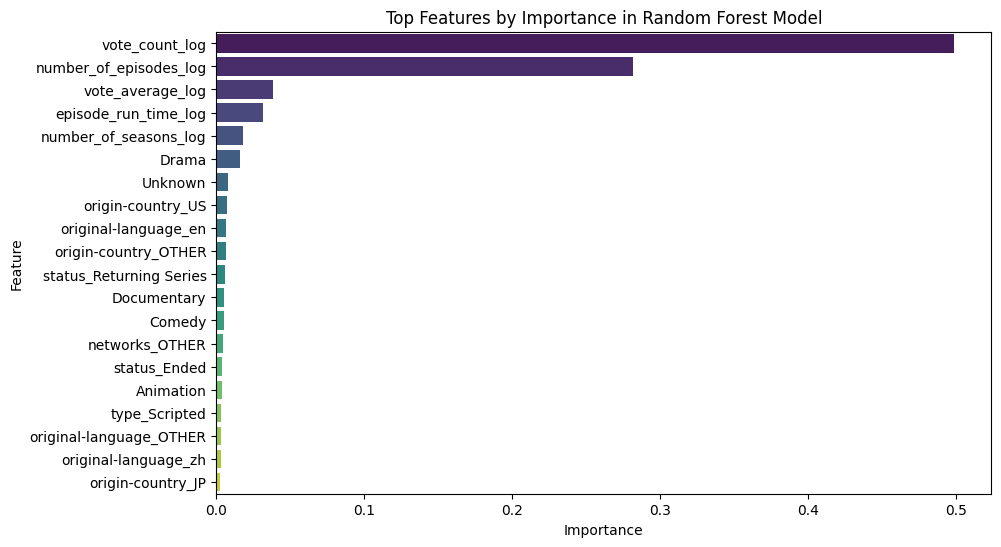

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Get feature importances
feature_importances = rf.feature_importances_

features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort features by importance
features_df = features_df.sort_values(by='Importance', ascending=False).head(20)  # Top 10 features

# Plot the minimal depth approximation (importance) distribution
plt.figure(figsize=(10, 6))
sns.barplot(y='Feature', x='Importance', data=features_df, palette="viridis")
plt.title("Top Features by Importance in Random Forest Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


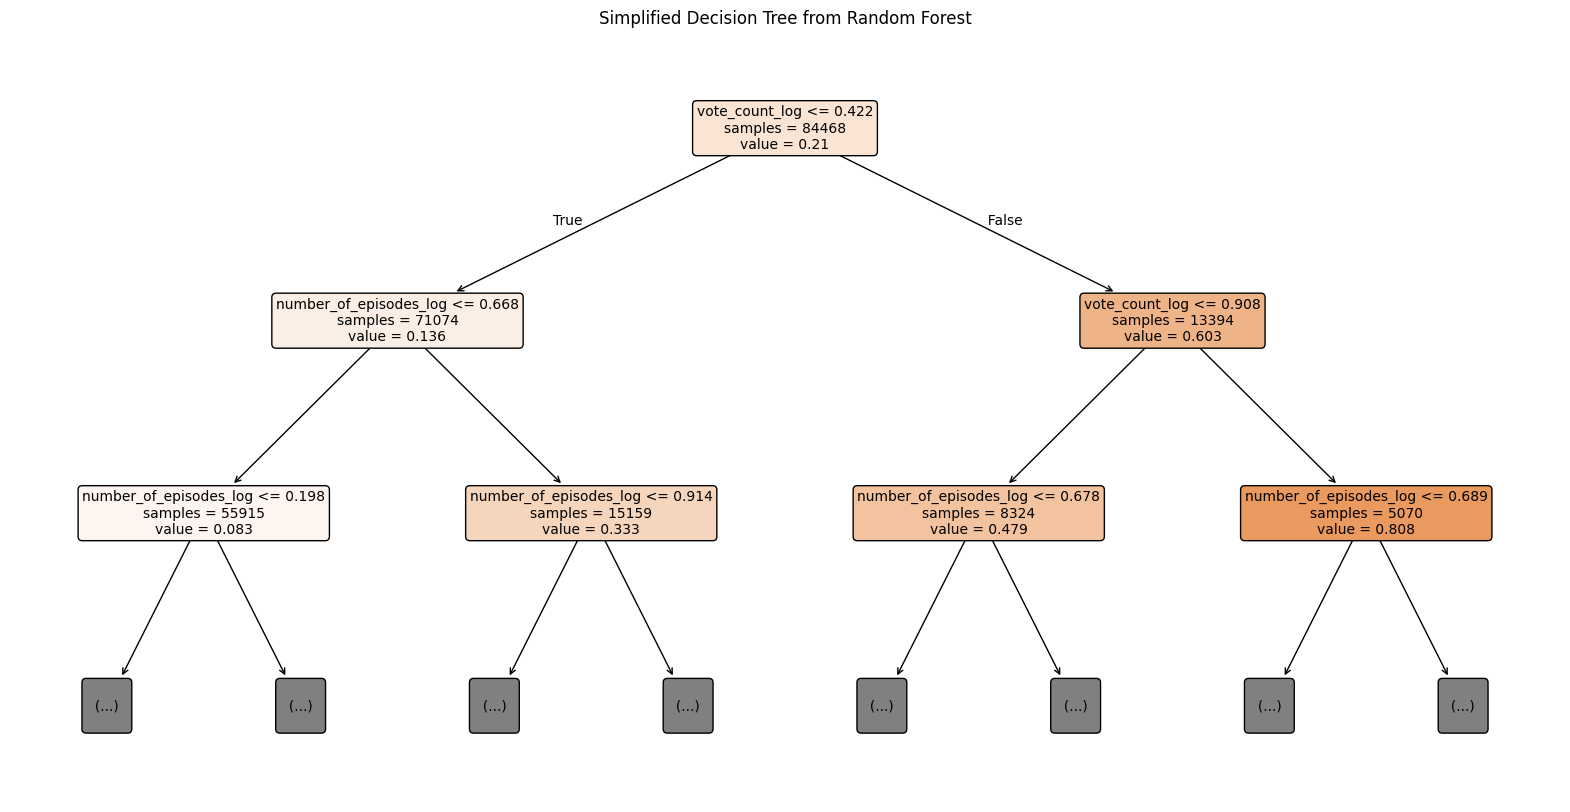

In [58]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

max_depth = 2
single_tree = rf.estimators_[10]  

# Plot the tree with simplified node labels
plt.figure(figsize=(20, 10))
plot_tree(single_tree, 
          feature_names=X.columns, 
          filled=True, 
          rounded=True, 
          fontsize=10, 
          max_depth=max_depth,
          impurity=False,          # Hide impurity (squared error for regression trees)
          proportion=False)         # Hide samples proportion
plt.title("Simplified Decision Tree from Random Forest")
plt.show()


### Decision Tree Graph (by Random Forest) without Logarithmic Values

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define features and target variable
# Define features and target variable
X = df[['number_of_seasons', 'number_of_episodes', 'vote_count', 
        'vote_average', 'episode_run_time', 
        # Genres
        'Action & Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 
        'Drama', 'Family', 'History', 'Kids', 'Music', 'Musical', 'Mystery', 
        'News', 'Reality', 'Romance', 'Sci-Fi & Fantasy', 'Soap', 'Talk', 
        'Unknown', 'War & Politics', 'Western',
        # Original Language
        'original-language_en', 'original-language_zh', 'original-language_ja', 
        'original-language_ko', 'original-language_de', 'original-language_fr', 
        'original-language_es', 'original-language_pt', 'original-language_ru', 
        'original-language_nl', 'original-language_OTHER', 
        # Created By
        'created-by_Shotaro Ishinomori', 'created-by_John de Mol', 
        'created-by_Adrián Suar', 'created-by_Simon Fuller', 
        'created-by_Ekta Kapoor', 'created-by_Na Young-seok', 
        'created-by_Yang Li-Hua', 'created-by_Joseph Barbera, William Hanna', 
        'created-by_R.J. Nuevas', 'created-by_Mark Burnett', 
        'created-by_OTHER', 
        # Networks
        'networks_BBC One', 'networks_YouTube', 'networks_Netflix', 
        'networks_ITV1', 'networks_BBC Two', 'networks_ABC', 'networks_NBC', 
        'networks_TVB Jade', 'networks_CBS', 'networks_Channel 4', 
        'networks_OTHER', 
        # Origin Country
        'origin-country_US', 'origin-country_JP', 'origin-country_GB', 
        'origin-country_CN', 'origin-country_DE', 'origin-country_KR', 
        'origin-country_CA', 'origin-country_FR', 'origin-country_AU', 
        'origin-country_BR', 'origin-country_OTHER', 
        # Production Companies
        'production-companies_TVB', 'production-companies_BBC', 
        'production-companies_Estúdios Globo', 'production-companies_NHK', 
        'production-companies_DR TV', 'production-companies_TV 2', 
        'production-companies_Televisa', 'production-companies_GMA Entertainment Group', 
        'production-companies_Česká televize', 'production-companies_ATV Enterprises Limited', 
        'production-companies_OTHER', 
        # Types
        'type_Documentary', 'type_Miniseries', 'type_News', 'type_Reality', 
        'type_Scripted', 'type_Talk Show', 'type_Video', 
        # Status
        'status_Canceled', 'status_Ended', 'status_In Production', 
        'status_Pilot', 'status_Planned', 'status_Returning Series'
]]
y = df['popularity']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor with specified parameters
rf = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=4, 
                           min_samples_split=10, random_state=42)
rf.fit(X_train, y_train)

# Predictions on test data
rf_predictions_test = rf.predict(X_test)

# Predictions on train data
rf_predictions_train = rf.predict(X_train)

# Calculate evaluation metrics for test set
test_mae = mean_absolute_error(y_test, rf_predictions_test)
test_mse = mean_squared_error(y_test, rf_predictions_test)
test_r2 = r2_score(y_test, rf_predictions_test)

# Calculate evaluation metrics for train set
train_mae = mean_absolute_error(y_train, rf_predictions_train)
train_mse = mean_squared_error(y_train, rf_predictions_train)
train_r2 = r2_score(y_train, rf_predictions_train)

print("Results with Grid Search Best Parameters + Non-Log Features:")
# Print Train set evaluation metrics
print(f'Train MAE: {train_mae:.4f}')
print(f'Train MSE: {train_mse:.4f}')
print(f'Train R^2: {train_r2:.4f}')

# Print Test set evaluation metrics
print(f'Test MAE: {test_mae:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test R^2: {test_r2:.4f}')

Results with Grid Search Best Parameters + Non-Log Features:
Train MAE: 0.0618
Train MSE: 0.0148
Train R^2: 0.7737
Test MAE: 0.0759
Test MSE: 0.0229
Test R^2: 0.6452


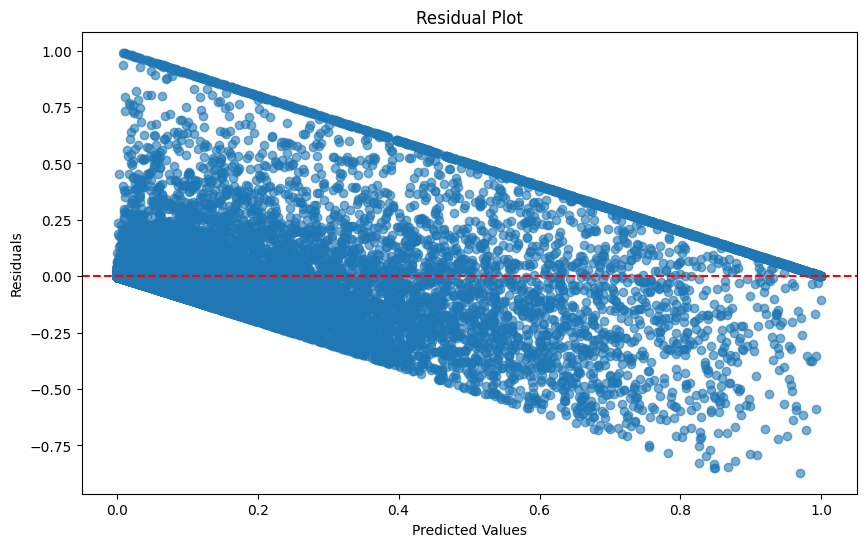

In [71]:
residuals = y_test - rf_predictions_test

# Create the residual plot
plt.figure(figsize=(10, 6))
plt.scatter(rf_predictions_test, residuals, alpha=0.6)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

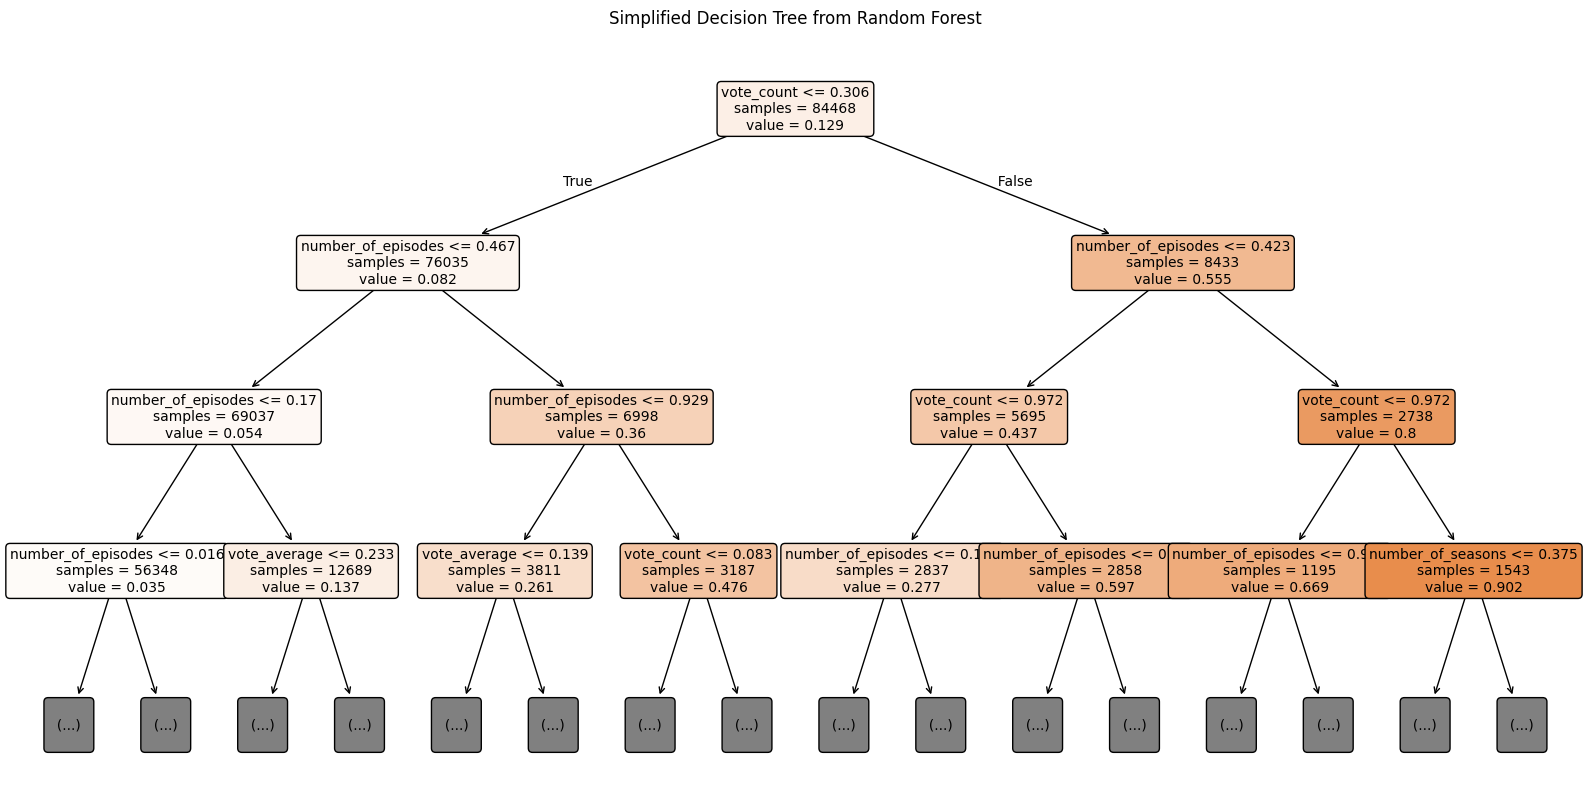

In [62]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

max_depth = 3
single_tree = rf.estimators_[10]  

# Plot the tree with simplified node labels
plt.figure(figsize=(20, 10))
plot_tree(single_tree, 
          feature_names=X.columns, 
          filled=True, 
          rounded=True, 
          fontsize=10, 
          max_depth=max_depth,
          impurity=False,          # Hide impurity (squared error for regression trees)
          proportion=False)         # Hide samples proportion
plt.title("Simplified Decision Tree from Random Forest")
plt.show()


In [63]:
# List of genre columns (adjust as necessary for your dataset)
genre_columns = ['Action & Adventure', 'Animation', 'Comedy', 'Crime', 
                 'Documentary', 'Drama', 'Family', 'History', 'Kids', 
                 'Music', 'Musical', 'Mystery', 'News', 'Reality', 
                 'Romance', 'Sci-Fi & Fantasy', 'Soap', 'Talk', 'Unknown', 
                 'War & Politics', 'Western']

# Create a dictionary to store the average popularity for each genre
average_popularity_per_genre = {}

for genre in genre_columns:
    # Calculate the average popularity for rows where the genre is 1
    avg_popularity = df.loc[df[genre] == 1, 'popularity'].mean()
    average_popularity_per_genre[genre] = avg_popularity

# Print the average popularity for each genre
print("Average Popularity per Genre:")
for genre, avg in average_popularity_per_genre.items():
    print(f'{genre}: {avg:.2f}')


Average Popularity per Genre:
Action & Adventure: 0.37
Animation: 0.31
Comedy: 0.25
Crime: 0.26
Documentary: 0.07
Drama: 0.25
Family: 0.25
History: 0.22
Kids: 0.26
Music: 0.15
Musical: 0.73
Mystery: 0.28
News: 0.15
Reality: 0.15
Romance: 0.26
Sci-Fi & Fantasy: 0.40
Soap: 0.42
Talk: 0.23
Unknown: 0.03
War & Politics: 0.19
Western: 0.50


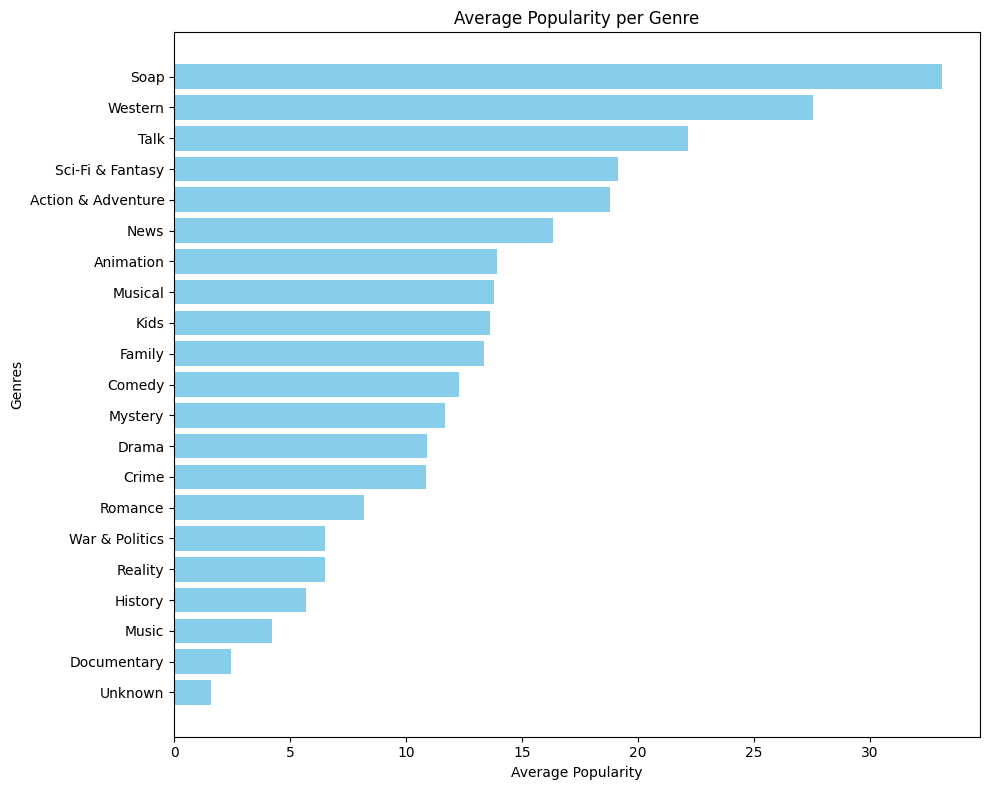

In [32]:
import matplotlib.pyplot as plt

# List of genre columns (adjust as necessary for your dataset)
genre_columns = ['Action & Adventure', 'Animation', 'Comedy', 'Crime', 
                 'Documentary', 'Drama', 'Family', 'History', 'Kids', 
                 'Music', 'Musical', 'Mystery', 'News', 'Reality', 
                 'Romance', 'Sci-Fi & Fantasy', 'Soap', 'Talk', 'Unknown', 
                 'War & Politics', 'Western']

# Create a dictionary to store the average popularity for each genre
average_popularity_per_genre = {}

for genre in genre_columns:
    # Calculate the average popularity for rows where the genre is 1
    avg_popularity = df.loc[df[genre] == 1, 'popularity'].mean()
    average_popularity_per_genre[genre] = avg_popularity

# Convert the dictionary to a sorted list of tuples (genre, average_popularity)
sorted_genres = sorted(average_popularity_per_genre.items(), key=lambda x: x[1], reverse=True)

# Separate the genres and popularity values
genres = [item[0] for item in sorted_genres]
popularity_values = [item[1] for item in sorted_genres]

# Create the bar graph
plt.figure(figsize=(10, 8))
plt.barh(genres, popularity_values, color='skyblue')
plt.xlabel('Average Popularity')
plt.ylabel('Genres')
plt.title('Average Popularity per Genre')
plt.gca().invert_yaxis()  # To display the highest values on top
plt.tight_layout()
plt.show()


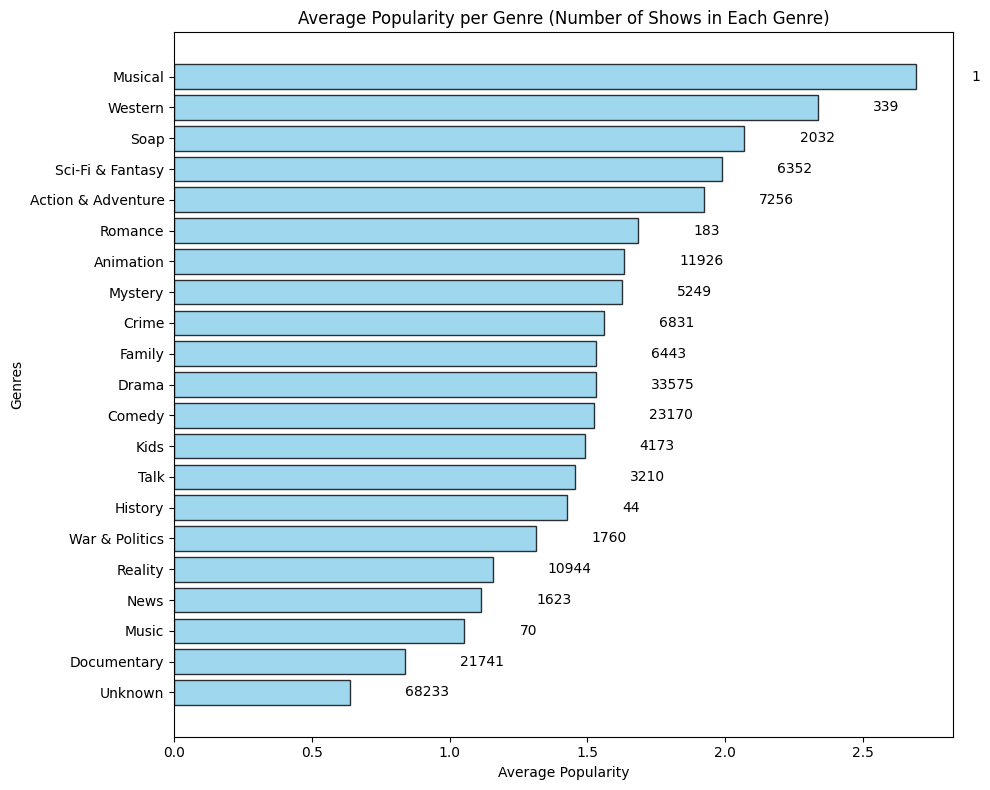

In [38]:
import matplotlib.pyplot as plt

# List of genre columns (adjust as necessary for your dataset)
genre_columns = ['Action & Adventure', 'Animation', 'Comedy', 'Crime', 
                 'Documentary', 'Drama', 'Family', 'History', 'Kids', 
                 'Music', 'Musical', 'Mystery', 'News', 'Reality', 
                 'Romance', 'Sci-Fi & Fantasy', 'Soap', 'Talk', 'Unknown', 
                 'War & Politics', 'Western']

# Create a dictionary to store the average popularity and count for each genre
genre_data = {}

for genre in genre_columns:
    # Filter rows where the genre is 1
    genre_shows = df[df[genre] == 1]
    # Calculate the average popularity and count of shows
    avg_popularity = genre_shows['popularity_log'].mean()
    count = genre_shows.shape[0]
    genre_data[genre] = (avg_popularity, count)

# Convert the dictionary to a sorted list of tuples (genre, average_popularity, count)
sorted_genres = sorted(genre_data.items(), key=lambda x: x[1][0], reverse=True)

# Separate the genres, popularity values, and counts
genres = [item[0] for item in sorted_genres]
popularity_values = [item[1][0] for item in sorted_genres]
show_counts = [item[1][1] for item in sorted_genres]

# Create the bar graph
plt.figure(figsize=(10, 8))
bars = plt.barh(genres, popularity_values, color='skyblue', edgecolor='black', alpha=0.8)

# Annotate with the count of shows for each genre
for bar, count in zip(bars, show_counts):
    plt.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height() / 2, f'{count}', va='center')

plt.xlabel('Average Popularity')
plt.ylabel('Genres')
plt.title('Average Popularity per Genre (Number of Shows in Each Genre)')
plt.gca().invert_yaxis()  # To display the highest values on top
plt.tight_layout()
plt.show()


/var/folders/n4/c3jxqdvx2l15c7ghrhjmd95m0000gn/T/ipykernel_71057/3155441149.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x='popularity_log', y='Genre', orient='h', palette='coolwarm')


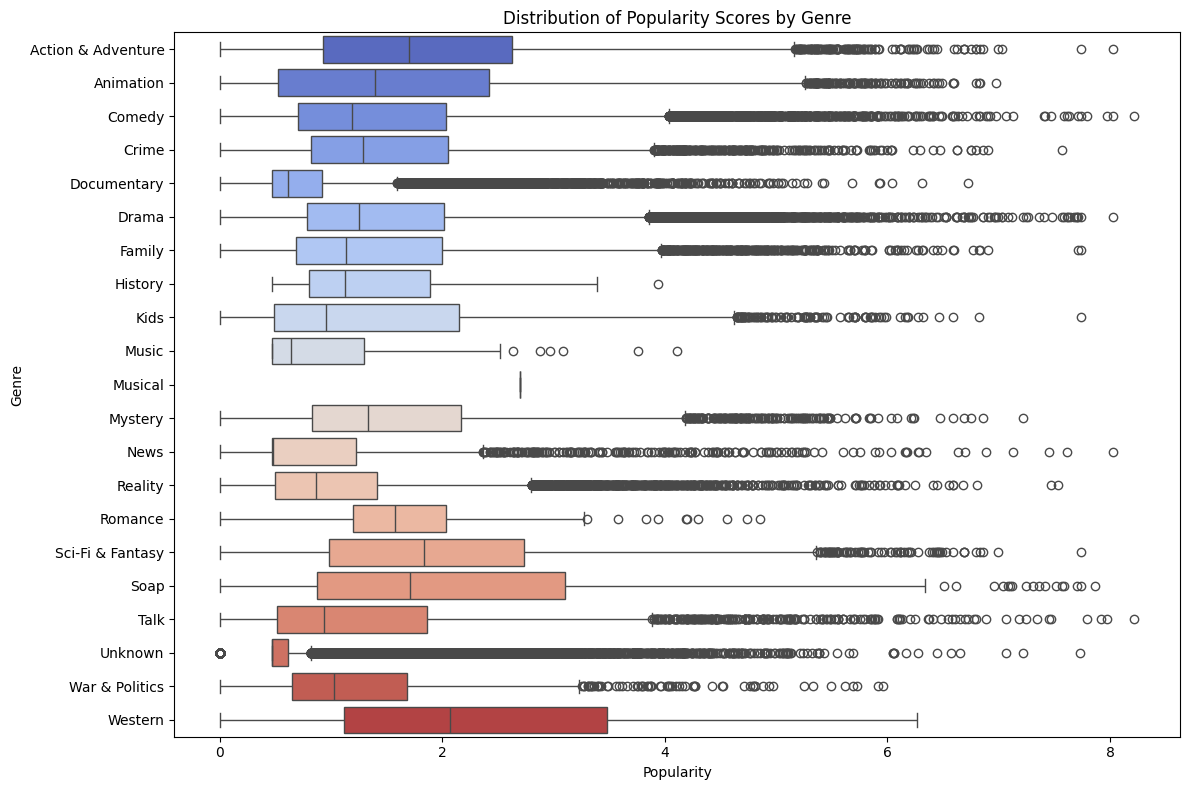

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the dataframe to create a long format for genres
genre_columns = ['Action & Adventure', 'Animation', 'Comedy', 'Crime', 
                 'Documentary', 'Drama', 'Family', 'History', 'Kids', 
                 'Music', 'Musical', 'Mystery', 'News', 'Reality', 
                 'Romance', 'Sci-Fi & Fantasy', 'Soap', 'Talk', 'Unknown', 
                 'War & Politics', 'Western']

# Add a column to identify genres (melt the data)
melted_df = df.melt(id_vars=['popularity_log'], value_vars=genre_columns, 
                    var_name='Genre', value_name='Is_In_Genre')

# Filter to include only rows where a show is part of a genre
filtered_df = melted_df[melted_df['Is_In_Genre'] == 1]

# Create a box plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=filtered_df, x='popularity_log', y='Genre', orient='h', palette='coolwarm')
plt.title('Distribution of Popularity Scores by Genre')
plt.xlabel('Popularity')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()


In [68]:
X = df[['number_of_seasons_log', 'number_of_episodes_log', 'vote_count_log', 
        'vote_average_log', 'episode_run_time_log', 
        # Genres
        'Action & Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 
        'Drama', 'Family', 'History', 'Kids', 'Music', 'Musical', 'Mystery', 
        'News', 'Reality', 'Romance', 'Sci-Fi & Fantasy', 'Soap', 'Talk', 
        'Unknown', 'War & Politics', 'Western',
        # Original Language
        'original-language_en', 'original-language_zh', 'original-language_ja', 
        'original-language_ko', 'original-language_de', 'original-language_fr', 
        'original-language_es', 'original-language_pt', 'original-language_ru', 
        'original-language_nl', 'original-language_OTHER', 
        # Created By
        'created-by_Shotaro Ishinomori', 'created-by_John de Mol', 
        'created-by_Adrián Suar', 'created-by_Simon Fuller', 
        'created-by_Ekta Kapoor', 'created-by_Na Young-seok', 
        'created-by_Yang Li-Hua', 'created-by_Joseph Barbera, William Hanna', 
        'created-by_R.J. Nuevas', 'created-by_Mark Burnett', 
        'created-by_OTHER', 
        # Networks
        'networks_BBC One', 'networks_YouTube', 'networks_Netflix', 
        'networks_ITV1', 'networks_BBC Two', 'networks_ABC', 'networks_NBC', 
        'networks_TVB Jade', 'networks_CBS', 'networks_Channel 4', 
        'networks_OTHER', 
        # Origin Country
        'origin-country_US', 'origin-country_JP', 'origin-country_GB', 
        'origin-country_CN', 'origin-country_DE', 'origin-country_KR', 
        'origin-country_CA', 'origin-country_FR', 'origin-country_AU', 
        'origin-country_BR', 'origin-country_OTHER', 
        # Production Companies
        'production-companies_TVB', 'production-companies_BBC', 
        'production-companies_Estúdios Globo', 'production-companies_NHK', 
        'production-companies_DR TV', 'production-companies_TV 2', 
        'production-companies_Televisa', 'production-companies_GMA Entertainment Group', 
        'production-companies_Česká televize', 'production-companies_ATV Enterprises Limited', 
        'production-companies_OTHER', 
        # Types
        'type_Documentary', 'type_Miniseries', 'type_News', 'type_Reality', 
        'type_Scripted', 'type_Talk Show', 'type_Video', 
        # Status
        'status_Canceled', 'status_Ended', 'status_In Production', 
        'status_Pilot', 'status_Planned', 'status_Returning Series'
]]
y = df['popularity_log']

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the training and testing data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics for the training data
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)  # Root Mean Squared Error
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for the testing data
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)  # Root Mean Squared Error
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print the results
print("Training Set Metrics:")
print(f"Mean Squared Error (MSE): {train_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {train_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {train_mae:.4f}")
print(f"R-squared (R2): {train_r2:.4f}")

print("\nTesting Set Metrics:")
print(f"Mean Squared Error (MSE): {test_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
print(f"R-squared (R2): {test_r2:.4f}")


Training Set Metrics:
Mean Squared Error (MSE): 0.0338
Root Mean Squared Error (RMSE): 0.1838
Mean Absolute Error (MAE): 0.1283
R-squared (R2): 0.6101

Testing Set Metrics:
Mean Squared Error (MSE): 0.0335
Root Mean Squared Error (RMSE): 0.1830
Mean Absolute Error (MAE): 0.1276
R-squared (R2): 0.6077


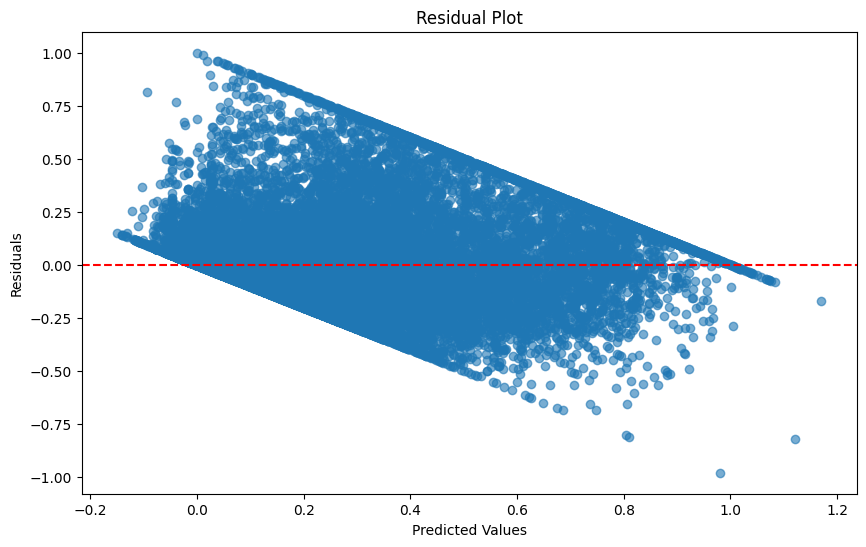

In [69]:
# https://how2matplotlib.com/how-to-create-a-residual-plot-in-python.html
residuals = y_test - y_test_pred

# Create the residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()